# Stochastic Multi-Armed Bandits on Simulated Data

In [1]:
import numpy as np
import arms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

## Bernoulli bandit models

For the UCB1 algorithm, we take : $\rho_t = \frac{\rho}{t^\gamma}$ with $\gamma$ the decay factor.

In [3]:
class Multi_Armed_Bandits_algorithms():
    
    def __init__(self, MAB, T, nb_simu=100, rho=5, decay=0.5, general_thompson=False):
        '''
        Parameters:
        
        MAB:
            Multi-armed bandit model
        T: int
            Lenght of the bandit game
        nb_simu: int
            Number of simulations
        rho: float
            uncertainty coefficient
        decay: float
            decay for rho
        general_thompson: bool
            Whether to apply the general thompson algorithm or the normal one
        '''
               
        self.MAB = MAB
        self.T = T
        self.nb_simu = nb_simu
        self.rho = rho
        self.decay = decay
        self.general_thompson = general_thompson
        
    def UCB1(self):
        '''
        Run the UCB algorithm
        '''
        K = len(self.MAB)

        Draws = np.zeros(self.T)
        Rewards = np.zeros(self.T)    
        N = np.zeros(K)
        Arms_mean_rewards = np.zeros(K)    
        Bounds = np.zeros(K)
        
        self.Rewards = np.zeros((self.nb_simu, self.T))
        self.Draws = np.zeros((self.nb_simu, self.T))

        for k in tqdm(range(self.nb_simu), desc="Simulating {}".format("UCB")):
            for t,arm in enumerate(self.MAB):
                N[t] += 1
                Rewards[t] = int(arm.sample())
                Draws[t] = t

                alpha = 1/N[t]
                Arms_mean_rewards[t] = (1-alpha)*Arms_mean_rewards[t] + alpha*Rewards[t]        
                Bounds[t] = Arms_mean_rewards[t] 

            for t in range(K,self.T):
                i = np.argmax(Bounds)
                Draws[t] = i
                Rewards[t] = int(self.MAB[i].sample())
                
                N[i]+=1
                alpha = 1/N[i]
                Arms_mean_rewards[i] = (1-alpha)*Arms_mean_rewards[i] + alpha*Rewards[t]        
                Bounds[i] = Arms_mean_rewards[i] + (self.rho/(t-K+1)**self.decay)*np.sqrt(np.log(t+1)/(2*N[i]))    
                
            self.Rewards[k, :] = Rewards
            self.Draws[k, :] = Draws

        return np.mean(self.Rewards,axis=0), np.mean(self.Draws,axis=0)
    
    def TS(self):
        '''
        Run the thompson algorithm
        '''
        K = len(self.MAB)

        Draws = np.zeros(self.T)
        Rewards = np.zeros(self.T)    
        N = np.zeros(K)
        Arms_rewards = np.zeros(K)    
        Bounds = np.zeros(K)
        
        self.Rewards = np.zeros((self.nb_simu, self.T))
        self.Draws = np.zeros((self.nb_simu, self.T))

        for k in tqdm(range(self.nb_simu), desc="Simulating {}".format("Thompson")):
            for t in range(self.T):
                Bounds = np.random.beta(Arms_rewards + 1, N - Arms_rewards +1)
                i = np.argmax(Bounds)
                Draws[t] = i
                Rewards[t] = int(self.MAB[i].sample())

                if self.general_thompson:
                    Rewards[t] = np.random.binomial(1, float(self.MAB[i].sample()))

                N[i]+=1
                Arms_rewards[i] += Rewards[t]              
            
            self.Rewards[k, :] = Rewards
            self.Draws[k, :] = Draws
        
        return np.mean(self.Rewards,axis=0), np.mean(self.Draws,axis=0)
        
    
    def naive(self):
        '''
        Run the naive algorithm
        '''
        K = len(self.MAB)

        Draws = np.zeros(self.T)
        Rewards = np.zeros(self.T)    
        N = np.zeros(K)
        Arms_mean_rewards = np.zeros(K)    

        self.Rewards = np.zeros((self.nb_simu, self.T))
        self.Draws = np.zeros((self.nb_simu, self.T))

        for k in tqdm(range(self.nb_simu), desc="Simulating {}".format("Naive")):
                 
            for t,arm in enumerate(self.MAB):
                N[t] += 1
                Rewards[t] = int(arm.sample())
                Draws[t] = t

                alpha = 1/N[t]
                Arms_mean_rewards[t] = (1-alpha)*Arms_mean_rewards[t] + alpha*Rewards[t]        


            for t in range(K,self.T):
                i = np.argmax(Arms_mean_rewards)
                Draws[t] = i
                Rewards[t] = int(self.MAB[i].sample())

                N[i]+=1
                alpha = 1/N[i]
                Arms_mean_rewards[i] = (1-alpha)*Arms_mean_rewards[i] + alpha*Rewards[t]  
                
            self.Rewards[k, :] = Rewards
            self.Draws[k, :] = Draws

        return np.mean(self.Rewards,axis=0), np.mean(self.Draws,axis=0)
    
    def plot_cumulative_regrets(self):
        '''
        Plot the cumulative regrets for the three algorithms with
        the Oracle regret curve.
        '''
        
        means = [el.mean for el in self.MAB]
        mu_max = np.max(means)

        rew1, draws1 = self.UCB1()
        reg1 = mu_max * np.arange(1, self.T + 1) - np.cumsum(rew1)
        rew2, draws2 = self.TS()
        reg2 = mu_max * np.arange(1, self.T + 1) - np.cumsum(rew2)

        rew3, draws3 = self.naive()
        reg3 = mu_max * np.arange(1, self.T + 1) - np.cumsum(rew3)

        # add oracle t -> C(p)log(t)

        def kl(x,y):
            return x*np.log(x/y) + (1-x)*np.log((1-x)/(1-y))

        def Compute_C_p(MAB):
            means = [el.mean for el in MAB]
            max_mean = means.pop(np.argmax(means))
            return np.sum((max_mean - np.array(means))/kl(np.array(means),max_mean))

        C_p = Compute_C_p(self.MAB)

        plt.figure(1)
        x = np.arange(1, self.T+1)
        plt.plot(x, reg1, label='UCB')
        if self.general_thompson: thom_label='General Thompson'
        else : thom_label='Thompson'
        plt.plot(x, reg2, label=thom_label)
        plt.plot(x, reg3, label='Naive')
        plt.plot(C_p*np.log(x), label="Oracle")

        plt.xlabel('Rounds')
        plt.ylabel('Cumulative Regret')

        plt.legend()
        #plt.show()

### Question 1 :

We'll compare the regret of Thompson Sampling with that of UCB1, for two different Bernoulli bandit problems.

The two Bernoulli bandit problem are the following :
- Four Bernoulli Arms : $\mathcal{B}(0.3)$, $\mathcal{B}(0.25)$, $\mathcal{B}(0.2)$ and $\mathcal{B}(0.1)$
- Four Bernoulli Arms : $\mathcal{B}(0.42)$, $\mathcal{B}(0.2)$, $\mathcal{B}(0.35)$ and $\mathcal{B}(0.15)$

We'll consider a horizon T=5000 for the simulations. We run 50 simulations. We'll also consider the decay $\gamma = 0.5$ and $\rho = 5$.

In [4]:
# First MAB
arm1 = arms.ArmBernoulli(0.30, random_state=np.random.randint(1, 312414))
arm2 = arms.ArmBernoulli(0.25, random_state=np.random.randint(1, 312414))
arm3 = arms.ArmBernoulli(0.20, random_state=np.random.randint(1, 312414))
arm4 = arms.ArmBernoulli(0.10, random_state=np.random.randint(1, 312414))

MAB1 = [arm1, arm2, arm3, arm4]

#Second MAB
arm1 = arms.ArmBernoulli(0.42, random_state=np.random.randint(1, 312414))
arm2 = arms.ArmBernoulli(0.2, random_state=np.random.randint(1, 312414))
arm3 = arms.ArmBernoulli(0.35, random_state=np.random.randint(1, 312414))
arm4 = arms.ArmBernoulli(0.85, random_state=np.random.randint(1, 312414))
arm5 = arms.ArmBernoulli(0.56, random_state=np.random.randint(1, 312414))

MAB2 = [arm1, arm2, arm3, arm4, arm5]

#Third MAB
arm1 = arms.ArmBernoulli(0.08, random_state=np.random.randint(1, 312414))
arm2 = arms.ArmBernoulli(0.7, random_state=np.random.randint(1, 312414))
arm3 = arms.ArmBernoulli(0.25, random_state=np.random.randint(1, 312414))
arm4 = arms.ArmBernoulli(0.1, random_state=np.random.randint(1, 312414))
arm5 = arms.ArmBernoulli(0.35, random_state=np.random.randint(1, 312414))
arm6 = arms.ArmBernoulli(0.2, random_state=np.random.randint(1, 312414))

MAB3 = [arm1, arm2, arm3, arm4, arm5, arm6]

Simulating Naive: 100%|██████████| 100/100 [00:03<00:00, 31.66it/s]


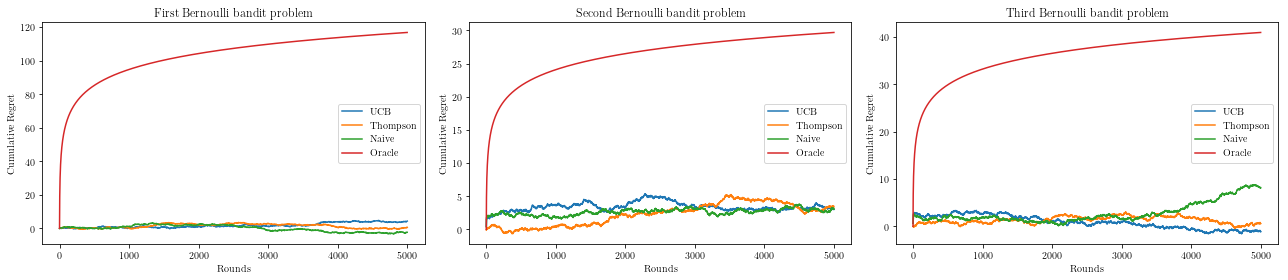

In [5]:
MAB_algos_1 = Multi_Armed_Bandits_algorithms(MAB1, T=5000, nb_simu=100, rho=5, decay=0.5, general_thompson=False)
MAB_algos_2 = Multi_Armed_Bandits_algorithms(MAB2, T=5000, nb_simu=100, rho=5, decay=0.5, general_thompson=False)
MAB_algos_3 = Multi_Armed_Bandits_algorithms(MAB3, T=5000, nb_simu=100, rho=5, decay=0.5, general_thompson=False)

plt.figure(figsize=(18,4))
plt.subplot(131)
MAB_algos_1.plot_cumulative_regrets()
plt.title("First Bernoulli bandit problem")

plt.subplot(132)
MAB_algos_2.plot_cumulative_regrets()
plt.title("Second Bernoulli bandit problem")

plt.subplot(133)
MAB_algos_3.plot_cumulative_regrets()
plt.title("Third Bernoulli bandit problem")

plt.tight_layout()
plt.show()

## Non-parametric bandits (bounded rewards)

### Question 2 :

We'll build a MultiArmedBandit model with not only Bernoulli arms, and observe the cumulative rewards for the three algorithms. For that purpose we'll use an adaptation of Thompson Sampling to handle non-binary rewards, proposed by Agrawal and Goyal, 2012.

After getting the non-binary reward $\tilde{r}$, we perform a Bernoulli trial with success probability $\tilde{r}$ and observe the output **$r$** which will be considered as the binary reward.

We'll consider the following MAB :


Simulating Naive: 100%|██████████| 50/50 [00:01<00:00, 32.35it/s]


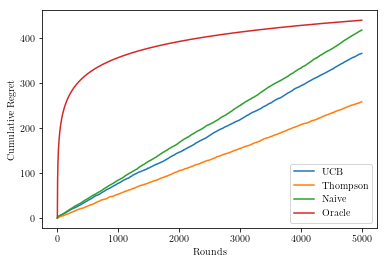

In [6]:
arm1 = arms.ArmBernoulli(0.35, random_state=np.random.randint(1, 312414))
arm2 = arms.ArmBeta(0.2, 0.3, random_state=np.random.randint(1, 312414))
arm3 = arms.ArmBeta(5, 8, random_state=np.random.randint(1, 312414))
arm4 = arms.ArmBeta(0.4, 2.3, random_state=np.random.randint(1, 312414))
arm5 = arms.ArmBernoulli(0.10, random_state=np.random.randint(1, 312414))
arm6 = arms.ArmExp(20, random_state=np.random.randint(1, 312414))
arm7 = arms.ArmExp(6, random_state=np.random.randint(1, 312414))
arm8 = arms.ArmBernoulli(0.20, random_state=np.random.randint(1, 312414))
arm9 = arms.ArmBernoulli(0.25, random_state=np.random.randint(1, 312414))

MAB = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8, arm9]

MAB_algos = Multi_Armed_Bandits_algorithms(MAB, T=5000, nb_simu=50, rho=5, decay=0.5, general_thompson=False)

MAB_algos.plot_cumulative_regrets()

The notion of complexity still makes sense according to the paper proposed. Indeed, for general nonparametric models, and under appropriate assumptions on the rate of convergence, the notion of complexity still holds as explained in the "Theorem 1".

# Linear Bandit on Real Data

In [4]:
import numpy as np
from linearmab_models import ToyLinearModel, ColdStartMovieLensModel
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
model.features.shape

(207, 30)

## Question 3

We'll implement the LinUCB algorithm for the provided MovieLens problem, for a horizon T=6000, and compare the performance against the random algorithm, and the $\epsilon-greedy$ algorithm.

For the LinearUCB and $\epsilon-greedy$ algorithms, we take : $\alpha_t = \frac{\alpha}{t^\gamma}$ with $\gamma$ the decay factor.

In [6]:
class LinearBandit():
    
    def __init__(self, model, T, nb_simu, lambd=0.1, alpha=20, decay=0.5, epsilon=0.3):
        '''
        Paramters:
        
        model:
            Linear MAB model
        T: int
            Lenght of the bandit game
        nb_simu: int
            Number of simulations
        lambda: float
            regularization coefficient
        alpha: float
            uncertainty coefficient
        decay: float
            decay for the uncertainty coefficient
        epsilon: float
            parameter for the epsilon greedy algorithm
        
        '''
        self.model = model
        self.T = T
        self.nb_simu = nb_simu
        self.lambd = lambd
        self.alpha = alpha
        self.decay = decay
        self.epsilon = epsilon
        
        self.run_epsilon = 0
        self.run_UCB = 0
        self.run_rand = 0
        
    def run_LinearUCB(self):
        '''
        Run LinearUCB algorithm
        '''
        self.run_UCB = 1
        
        d = self.model.n_features
        n_a = self.model.n_actions
        
        self.regret_UCB = np.zeros((self.nb_simu, self.T))
        self.norm_dist_UCB = np.zeros((self.nb_simu, self.T))
        lambd = 0.1 # Regularization coefficient

        for k in tqdm(range(self.nb_simu), desc="Simulating {}".format("UCB")):
            theta_hat = np.random.uniform(-1,1,d)
            upper_bound = self.model.features.dot(theta_hat)
            A_t = self.lambd * np.eye(d)
            b_t = np.zeros(d)

            for t in range(self.T):
                a_t = np.argmax(upper_bound) # algorithm picks the action
                r_t = self.model.reward(a_t) # get the reward

                # do something (update algorithm)
                A_t += np.matmul(self.model.features[a_t][:,None],self.model.features[a_t][None,:])
                b_t += self.model.features[a_t]*r_t
                theta_hat = np.linalg.solve(A_t,b_t)       
                A_t_1 = np.linalg.inv(A_t)

                upper_bound = model.features.dot(theta_hat) + (self.alpha/(t+1)**self.decay)*np.sqrt(np.einsum('ij,ij -> i',np.matmul(self.model.features,A_t_1), self.model.features))

                # store regret
                self.regret_UCB[k, t] = self.model.best_arm_reward() - r_t
                self.norm_dist_UCB[k, t] = np.linalg.norm(theta_hat - self.model.real_theta, 2)      
                
    def run_random(self):
        '''
        Run Random algorithm
        '''
        self.run_rand = 1
        
        d = self.model.n_features
        n_a = self.model.n_actions
        
        self.regret_random = np.zeros((self.nb_simu, self.T))
        self.norm_dist_random = np.zeros((self.nb_simu, self.T))
        lambd = 0.1 # Regularization coefficient

        for k in tqdm(range(self.nb_simu), desc="Simulating {}".format("Random")):
            theta_hat = np.random.uniform(-1,1,d)
            #upper_bound = self.model.features.dot(theta_hat)
            A_t = self.lambd * np.eye(d)
            b_t = np.zeros(d)

            for t in range(self.T):
                a_t = np.random.randint(0,n_a) # algorithm picks the action
                r_t = self.model.reward(a_t) # get the reward

                # do something (update algorithm)
                A_t += np.matmul(self.model.features[a_t][:,None],self.model.features[a_t][None,:])
                b_t += self.model.features[a_t]*r_t
                theta_hat = np.linalg.solve(A_t,b_t)       

                # store regret
                self.regret_random[k, t] = self.model.best_arm_reward() - r_t
                self.norm_dist_random[k, t] = np.linalg.norm(theta_hat - self.model.real_theta, 2)    

    def run_epsilon_greedy(self):
        '''
        Run Epsilon-Greedy algorithm
        '''
        
        self.run_epsilon = 1
        
        d = self.model.n_features
        n_a = self.model.n_actions
        
        self.regret_epsilon = np.zeros((self.nb_simu, self.T))
        self.norm_dist_epsilon = np.zeros((self.nb_simu, self.T))
        lambd = 0.1 # Regularization coefficient

        for k in tqdm(range(self.nb_simu), desc="Simulating {}".format("Epsilon Greedy")):
            theta_hat = np.random.uniform(-1,1,d)
            upper_bound = self.model.features.dot(theta_hat)
            A_t = self.lambd * np.eye(d)
            b_t = np.zeros(d)

            for t in range(self.T):
                beta = np.random.binomial(1,1-self.epsilon)
                a_t = beta*np.argmax(upper_bound) + (1-beta)*np.random.randint(0,n_a) # algorithm picks the action
                r_t = self.model.reward(a_t) # get the reward

                # do something (update algorithm)
                A_t += np.matmul(self.model.features[a_t][:,None],self.model.features[a_t][None,:])
                b_t += self.model.features[a_t]*r_t
                theta_hat = np.linalg.solve(A_t,b_t)       
                A_t_1 = np.linalg.inv(A_t)

                upper_bound = model.features.dot(theta_hat) + (self.alpha/(t+1)**self.decay)*np.sqrt(np.einsum('ij,ij -> i',np.matmul(self.model.features,A_t_1), self.model.features))

                # store regret
                self.regret_epsilon[k, t] = self.model.best_arm_reward() - r_t
                self.norm_dist_epsilon[k, t] = np.linalg.norm(theta_hat - self.model.real_theta, 2)                 
                
    def plot_results(self):
        '''
        Plot cumulative regrets for the runned algorithms, and the 
        difference between computed theta and real theta
        '''
        if self.run_UCB : 
            mean_norms_UCB = np.mean(self.norm_dist_UCB,axis=0)
            mean_regret_UCB = np.mean(self.regret_UCB,axis=0)
            
        if self.run_rand : 
            mean_norms_random = np.mean(self.norm_dist_random,axis=0)
            mean_regret_random = np.mean(self.regret_random,axis=0)
        
        if self.run_epsilon : 
            mean_norms_epsilon = np.mean(self.norm_dist_epsilon,axis=0)
            mean_regret_epsilon = np.mean(self.regret_epsilon,axis=0)
        
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        
        if self.run_UCB : plt.plot(mean_norms_UCB, label="UCB")
        if self.run_rand : plt.plot(mean_norms_random, label="Random")
        if self.run_epsilon : plt.plot(mean_norms_epsilon, label="Epsilon Greedy")
        
        plt.ylabel('$||\Theta - \widehat{\Theta}||_2$', fontsize=16)
        plt.xlabel('Rounds', fontsize=16)
        plt.legend()

        plt.subplot(122)
        
        if self.run_UCB : plt.plot(mean_regret_UCB.cumsum(), label="UCB")
        if self.run_rand : plt.plot(mean_regret_random.cumsum(), label="Random")
        if self.run_epsilon : plt.plot(mean_regret_epsilon.cumsum(), label="Epsilon Greedy")
        
        plt.ylabel('Cumulative Regret', fontsize=16)
        plt.xlabel('Rounds', fontsize=16)
        plt.legend()

        plt.tight_layout()
        plt.show()

In [7]:
random_state = np.random.randint(0, 24532523)
model = ColdStartMovieLensModel(
     random_state=random_state,
     noise=0.1)

We run 50 simulations and play with the parameters, with a fixed decay $\gamma=0.5$.

We finally choose the following parameters **(see below justification)** :

- $\alpha$ = 70 with $\alpha_t = \frac{\alpha}{\sqrt{t}}$ the decayed uncertainty coefficient
- $\lambda$ = 0.1
- $\epsilon$ = 0.3

and obtain the following results :

Simulating Epsilon Greedy: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


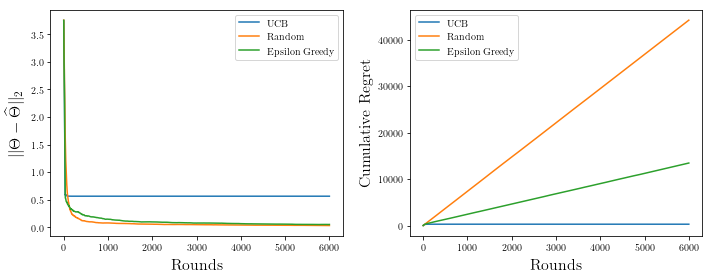

In [10]:
LinBand = LinearBandit(model, T=6000, nb_simu=50, lambd=0.1, alpha=70, decay=0.5, epsilon=0.3)

LinBand.run_LinearUCB()
LinBand.run_random()
LinBand.run_epsilon_greedy()

LinBand.plot_results()

### Choice of $\alpha$

We remark that if we decrease $\alpha$ from 70 to 10 for example, with all the other parameters fixed, we favorise the exploitation over the exploration, and we obtain same cumulative regret, but worse $||\theta - \hat{\theta}||_2$ :

Simulating Epsilon Greedy: 100%|██████████| 50/50 [00:49<00:00,  1.01s/it]


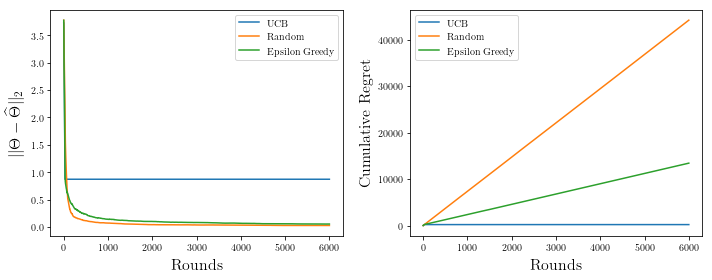

In [11]:
LinBand = LinearBandit(model, T=6000, nb_simu=50, lambd=0.1, alpha=10, decay=0.5, epsilon=0.3)

LinBand.run_LinearUCB()
LinBand.run_random()
LinBand.run_epsilon_greedy()

LinBand.plot_results()

**We choose $\alpha$ = 70**

### Choice of $\epsilon$

If we increase $\epsilon$ for a value above 0.5 (we favorize exploration over exploitation), we obtain worse cumulative regret for the $\epsilon$ greedy as shown below :

Simulating Epsilon Greedy: 100%|██████████| 50/50 [00:48<00:00,  1.00it/s]


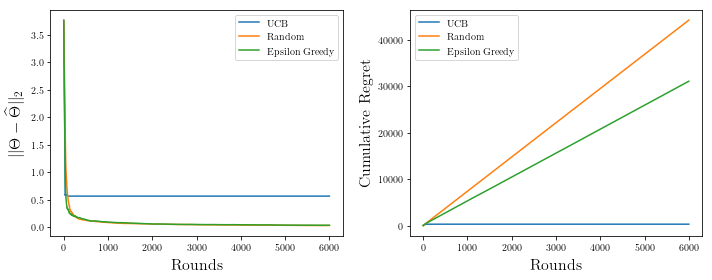

In [12]:
LinBand = LinearBandit(model, T=6000, nb_simu=50, lambd=0.1, alpha=70, decay=0.5, epsilon=0.7)

LinBand.run_LinearUCB()
LinBand.run_random()
LinBand.run_epsilon_greedy()

LinBand.plot_results()

**We choose $\epsilon=0.3$**

### Choice of $\lambda$

If we increase $\lambda$ from 0.1 to 0.8, we obtain similar cumulative regret, but worse $||\theta - \hat{\theta}||_2$ :

Simulating Epsilon Greedy: 100%|██████████| 50/50 [00:47<00:00,  1.08it/s]


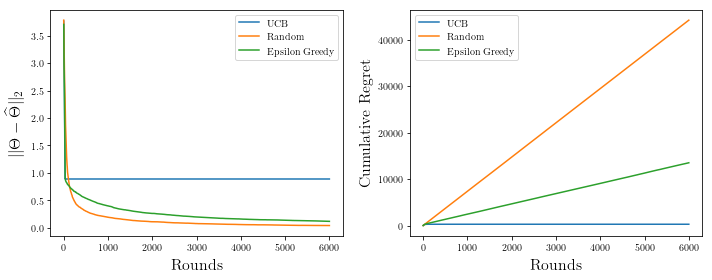

In [13]:
LinBand = LinearBandit(model, T=6000, nb_simu=50, lambd=0.8, alpha=70, decay=0.5, epsilon=0.3)

LinBand.run_LinearUCB()
LinBand.run_random()
LinBand.run_epsilon_greedy()

LinBand.plot_results()